# LING 571 Final Project
## --------------------------------------
Author: Dylan Watson <br>
Professor: Rob Malouf <br>
Course: LING 571: Computational Linguistics

## Introduction:
For this project, I will be using methods of computational linguistics and machine learning to categorize news headlines and text as well as analyzing linguistic differences between categories. 

## Question:
How can we classify news text into categories using computational linguistic techniques and what are the linguistic differences between these categories?

## The Dataset:
The dataset I have chosen contains data on 210k news articles written by HuffPost between the years 2012 and 2022. The dataset is provided by a user named Rishabh Misra on Kaggle and will be accredited in the citations at the bottom.
#### Import Libraries:

In [25]:
# Had to pip everything b/c opened Jupyter in new Anacondas environment running Python 3.10.13
# because tensorflow version >2.10 doesn't support gpu acceleration on Windows 10... :(
# Needs CUDA 11.2.0 and cuDNN 8.1.0
#!pip install tensorflow==2.10.0 
#!pip install tensorflow
#!pip install pandas
#!pip install matplotlib
#!pip install nltk
#!pip install scikit-learn
#!pip install gensim
#!pip install nbconvert
#!pip install pyppeteer

In [21]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import string
import numpy as np
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.10.0


#### Import Data:
The data in the json file is organized as individual json objects per article/row and must be read in row by row to a dataframe instead of all at once.

In [6]:
data = []
with open('News_Category_Dataset_v3.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))
news_data_df = pd.DataFrame(data)

## Exploratory Data Analysis:
Before we begin with any manipulation of the data, lets take a look at what data we have and how its structured.

In [5]:
print("Head:")
print("----------")
print(news_data_df.head())
print("\nDescribe:")
print("----------")
print(news_data_df.describe())
print("\nInfo:")
print("----------")
print(news_data_df.info())
print("\nData Types:")
print("----------")
print(news_data_df.dtypes)
print("\nMissing:")
print("----------")
print(news_data_df.isnull().sum())
print("\nColumns:")
print("----------")
print(news_data_df.columns)

Head:
----------
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until

#### EDA Findings: 
Columns: We find that we have 6 columns, they are link, headline, category, short_description, authors, and date. <br>
<br>
Missing: There are no missing values. This dataset is clean! :) <br>
<br>
Data Types: All datatypes of these columns are objects. Some may need to be converted to strings for text analysis. <br>
<br>
Describe: We find that are exactly 209,527 articles/rows. There also may be 19,712 articles that lack a short_description despite not appearing as null. Will have to check and possibly remove those. <br>
<br>
Head: Finally, here we can see what the data of each column actually looks like for a more intuitive undertstanding of it.

#### Target Feature (Category) Bar Chart:
For the classification of news articles according to a linguistic analysis of their text, we will use the "category" column as our target value in modeling as well as how we will separate the articles for other analysis.

In [6]:
category_counts = news_data_df['category'].value_counts()

In [7]:
print("Category Counts:")
print("----------")
print(category_counts)
print("\nNum of Categories")
print("----------")
print(len(category_counts))

Category Counts:
----------
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CUL

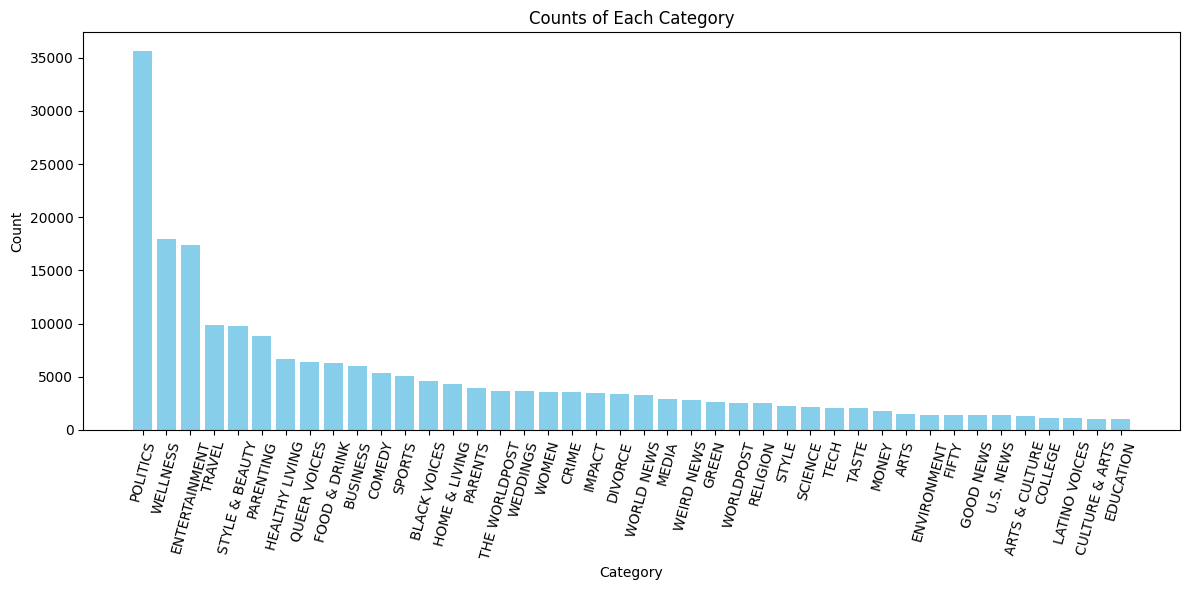

In [8]:
categories = category_counts.index
counts = category_counts.values
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.title('Counts of Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

#### Target Feature (Category) Findings:
There are 42 unique categories. They do not seem to overlap or need any cleaning as they are consistent in format. The most popular in terms of frequency is POLITICS and the least is EDUCATION. The distribution of frequencies is right skewed and falls off rapidly approaching an asymptote of 10k. These are all the values we will be attempting to predict based on text analysis.

## Cleaning:
Lets check to see if some of those short_descriptions are actually blank and remove them. Lets also remove the date, authors, and link features b/c the focus of this project is on computational linguistics and we are most interested in the headline, short_description, and category features.

In [7]:
columns_to_drop = ['link', 'authors', 'date']
news_data_cleaned_df = news_data_df.drop(columns=columns_to_drop)

In [8]:
news_data_cleaned_df = news_data_cleaned_df[(news_data_cleaned_df['headline'] != '') & (news_data_cleaned_df['short_description'] != '')]
print(news_data_cleaned_df.describe())

              headline  category  \
count           189814    189814   
unique          188417        42   
top     Sunday Roundup  POLITICS   
freq                90     32441   

                                        short_description  
count                                              189814  
unique                                             187020  
top     Welcome to the HuffPost Rise Morning Newsbrief...  
freq                                                  192  


By removing all rows in which the headline or short_description features are empty (but not null) we reduced the number of articles / rows by 19,713 to a new number of 189,814.

## Text Processing:
Here we need to tokenize, lowercase, remove punctuation, remove stopwords, stem, lemmatize, and normalize the text before we can feed it to a model. <br>
<br>
Lowercasing - converting all characters to lowercase. <br>
Remove Punctuation - as implied. Remove commas, periods, and all other symbols. <br>
Remove Stopwords - stopwords are commonly used words in the english language that are mostly for grammatical purposes but don't contain as much value individually. <br>
Stemming - convert words down to their base word. Plurals, words that end with 'ing', 'ed', 'es', 'er' May not be a word. <br>
Lemmatize - group different inflections of words to same word. Still keeps some context though unlike stemming. <br>
<br>
(yes I know stemming and lemmatizing do quite similar things to text but I really needed to reduce the amount of data as much as possible so my computer could train a model on it, my cpu is crying)

In [12]:
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

In [13]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in punctuation]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

*The cell below takes a minute!

In [14]:
news_data_processed_df = news_data_cleaned_df.copy()
news_data_processed_df['headline'] = news_data_cleaned_df['headline'].apply(preprocess_text)
news_data_processed_df['short_description'] = news_data_cleaned_df['short_description'].apply(preprocess_text)

#### Comparing Processed & Unprocessed Text:

In [14]:
print("Cleaned Original Text:")
print("----------")
print(news_data_cleaned_df.head())
print("\nProcessed Text:")
print("----------")
print(news_data_processed_df.head())

Cleaned Original Text:
----------
                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description  
0  Health experts said it is too early to predict...  
1  He was subdued by passengers and crew when he ...  
2  "Until you have a dog you don't understand wha...  
3  "Accidentally put grown-up toothpaste on my to...  
4  Amy Cooper accused investment firm Franklin Te...  

Processed Text:
----------
                                            headline   category  \
0          million american roll sleev covid booster  U.S. NEWS   
1  american airlin flyer charg ban life punch fli...  U.S. NEWS   
2   

#### Text Processing Result:
After processing the text we can verify that the columns are still aligned and can see that all the appropriate text manipulation has worked. For example "23 Of The Funniest Tweets About Cats And Dogs" becomes simplified down to "funniest tweet cat dog week." This reduces the total number of unique tokens while still maintaining most of the valuable context allowing us to more efficiently train a model on the data. Lets see exactly how much this rtext processing has reduced the amount of unique tokens.



## Processed Text Analysis:

In [15]:
news_data_cleaned_combined_df = pd.DataFrame(columns=['combined_text', 'category'])
news_data_cleaned_combined_df['category'] = news_data_cleaned_df['category'].copy()
news_data_cleaned_combined_df['combined_text'] = news_data_cleaned_df['headline'] + ' ' + news_data_cleaned_df['short_description']

news_data_processed_combined_df = pd.DataFrame(columns=['combined_text', 'category'])
news_data_processed_combined_df['category'] = news_data_processed_df['category'].copy()
news_data_processed_combined_df['combined_text'] = news_data_processed_df['headline'] + ' ' + news_data_processed_df['short_description']

In [16]:
cleaned_combined_all = news_data_cleaned_combined_df['combined_text'].str.cat(sep=' ')
processed_combined_all = news_data_processed_combined_df['combined_text'].str.cat(sep=' ')
print("Total Num of Cleaned Original Tokens")
print("----------")
print(len(cleaned_combined_all))
print("\nTotal Num of Unique Cleaned Original Tokens")
print("----------")
print(len(set(word_tokenize(cleaned_combined_all))))

print("\n\nTotal Num of Processed Tokens")
print("----------")
print(len(processed_combined_all))
print("\nTotal Num of Unique Processed Tokens")
print("----------")
print(len(set(word_tokenize(processed_combined_all))))

Total Num of Cleaned Original Tokens
----------
35455470

Total Num of Unique Cleaned Original Tokens
----------
155651


Total Num of Processed Tokens
----------
21113280

Total Num of Unique Processed Tokens
----------
57561


#### Amount of Text Reduction:
The text processing reduced the number of word tokens by 40.5% from 35.5 million to 21.1 million. Even more important, the number of unique tokens was reduced by 63.0% from 155.7k down to 57.6k.

#### Most Frequent Tokens:

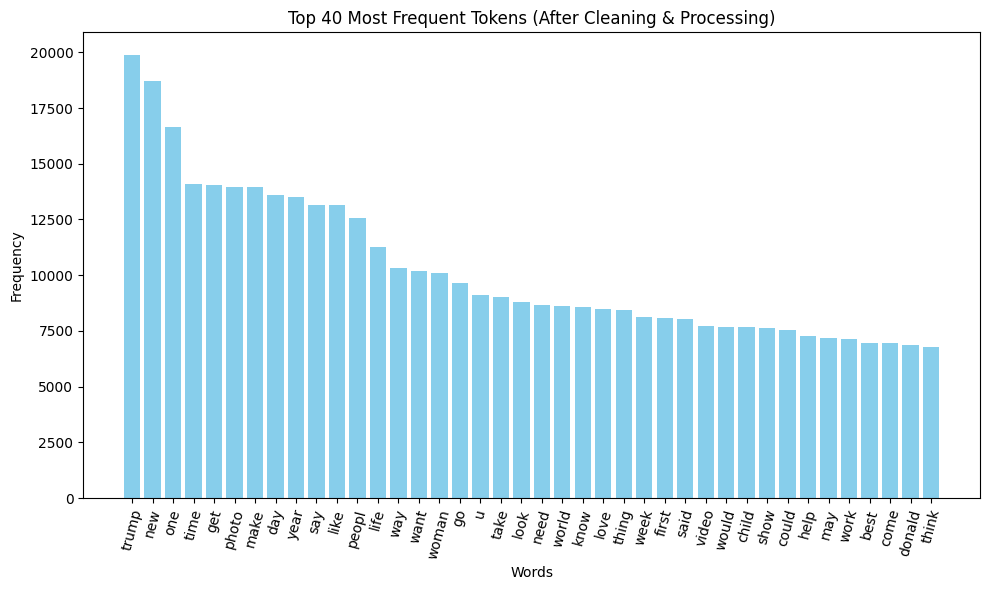

In [17]:
word_freq = Counter(word_tokenize(processed_combined_all))
top_n = 40
top_words = dict(word_freq.most_common(top_n))
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values(), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top ' + str(top_n) + ' Most Frequent Tokens (After Cleaning & Processing)')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

#### Token Findings:
In this chart we find the most frequent tokens after processing the text. As we are looking at news articles and with politics being the most frequent category, there is no surprise that the token 'Trump' lands first in the list due to his highly controversial nature during his presidency.

## Splitting:
Lets split the data into two sets, a training set to train the model and a test set to evaluate the performance of the model. Additionally, we'll split the training and test sets into x and y variables to represent the predictive and target features.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(news_data_processed_combined_df['combined_text'], news_data_processed_combined_df['category'], test_size=0.2, random_state=42)

## Model Creation / Training:
For our model I will try to use a recurrent neural network using Tensorflow to output a confusion matrix of the probabilities of each category for each row of combined_text. The category with the greatest probability will be assigned as the predicted category of the combined_text. I've also implemented early stopping so that if the loss and validation loss begin to diverse due to overfitting that the training will stop. Additonally, I've plotted the loss and validation loss to see the training progress visually. 

Epoch 1/50
2373/2373 [==============================] - 20s 8ms/step - loss: 2.3432 - accuracy: 0.4097 - val_loss: 1.8013 - val_accuracy: 0.5279
Epoch 2/50
2373/2373 [==============================] - 20s 8ms/step - loss: 1.7115 - accuracy: 0.5570 - val_loss: 1.6088 - val_accuracy: 0.5702
Epoch 3/50
2373/2373 [==============================] - 19s 8ms/step - loss: 1.5308 - accuracy: 0.5967 - val_loss: 1.5264 - val_accuracy: 0.5872
Epoch 4/50
2373/2373 [==============================] - 19s 8ms/step - loss: 1.4226 - accuracy: 0.6203 - val_loss: 1.4935 - val_accuracy: 0.5967
Epoch 5/50
2373/2373 [==============================] - 19s 8ms/step - loss: 1.3475 - accuracy: 0.6360 - val_loss: 1.4878 - val_accuracy: 0.5977
Epoch 6/50
2373/2373 [==============================] - 20s 8ms/step - loss: 1.2896 - accuracy: 0.6488 - val_loss: 1.4838 - val_accuracy: 0.6008
Epoch 7/50
2373/2373 [==============================] - 19s 8ms/step - loss: 1.2364 - accuracy: 0.6612 - val_loss: 1.4782 - val_ac

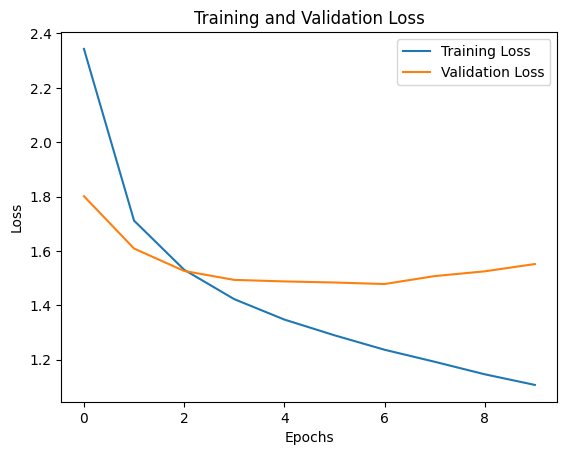

In [27]:
# Tokenize
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encode
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Number of classes
num_classes = 42

# RNN Architecture
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=32, input_length=max_len))
# model.add(Flatten())
model.add(LSTM(64, return_sequences=False))
# model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_encoded, epochs=50, batch_size=64, 
                    validation_data=(X_test_pad, y_test_encoded), callbacks=[early_stopping])

# Plotting Loss and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation:
Now that the model is trained, lets run the test dataset through the trained model and see how it performs. 

In [28]:
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
class_report = classification_report(y_test_encoded, y_pred)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)

1187/1187 [==============================] - 3s 2ms/step
Accuracy: 0.602613091468811

Confusion Matrix:
 [[ 63   3   1 ...   0   0   0]
 [ 11  44   5 ...   6   1   0]
 [  6   3 291 ...   2   3   0]
 ...
 [  0   2  13 ... 172   1   0]
 [  0   1   3 ...   1 203  12]
 [  4   1   1 ...   0  19  93]]


In [29]:
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred)

# classification report
class_report = classification_report(y_test_original, y_pred_original)

# Print
print("\nClassification Report with Original Category Names:\n", class_report)


Classification Report with Original Category Names:
                 precision    recall  f1-score   support

          ARTS       0.34      0.36      0.35       173
ARTS & CULTURE       0.35      0.17      0.23       259
  BLACK VOICES       0.50      0.34      0.40       862
      BUSINESS       0.46      0.44      0.45       947
       COLLEGE       0.33      0.31      0.32       178
        COMEDY       0.53      0.41      0.46       926
         CRIME       0.45      0.50      0.47       559
CULTURE & ARTS       0.47      0.29      0.36       236
       DIVORCE       0.72      0.76      0.74       713
     EDUCATION       0.45      0.23      0.30       186
 ENTERTAINMENT       0.61      0.72      0.66      3009
   ENVIRONMENT       0.39      0.21      0.27       290
         FIFTY       0.36      0.04      0.07       230
  FOOD & DRINK       0.60      0.76      0.67      1258
     GOOD NEWS       0.24      0.06      0.09       187
         GREEN       0.34      0.45      0.39    

#### Classification Report Context:
Precision: the accuracy of positive predictions. <br>
Recall: ratio of correctly predicted positives to actual positives. <br>
F1-Score: mean of precision and recall. <br>
Support: number of actual occurrences of category in dataset.

#### Evaluation Findings:
This initial model was found to be 60.3% accurate. This model could be improved by vectorizing the text and or modifying the neural network architecture. Looking at the classification report we find that there are some inequities in the model's ability to predict certain categories over others. In particular the model predicted some categories well such as "STYLE & BEAUTY" with an f1-score of 0.79, "WEDDINGS" at 0.75, "POLITICS" at 0.77, and "DIVORCE" at 0.74. On the other hand, the model struggled with categories like "U.S. NEWS" at 0.02, "GOOD NEWS" at 0.09, and "TASTE" at 0.02. Why is that? It's possible that the text processing ended up losing too much context preventing the model from effectively predicting some categories. Additionally, the frequency (support) of categories was not even. The categories that were higher in frequency (support) had more data for the model to learn while categories with less frequency provided an inadequate volume of data for the model to learn. This could potentially be solved by upscaling the catagories so that the distribution of categories is uniform. However, from a linguistic perspective, some categories may have a more unique set of tokens to differentiate themselves from others. If the set of processed tokens of two categories is too similar it may be more challenging to differentiate them predictively. Lets look at what tokens that the model found to be most indicative for each category to learn more about each one.

## Categorical Linguistic Analysis:
Lets see what tokens were weighted highest for each category in the model to see if we can find trends. ... I spent hours trying to get this to work to no avail. I cannot seem to analyze weights in the model to determine what tokens correlate to what categories. Maybe if it were a simple linear model I could use the token coefficients to see their correlations to each category. Alternatively, I could have just looked at the already pre-labelled data to find words that stood out in each area with more time allotted.

In [37]:
'''
embedding_weights = model.layers[0].get_weights()[0]  # Assuming the embedding layer is the first layer (index 0)
dense_layer_weights = model.layers[-1].get_weights()[0]  # Weights of the Dense layer

word_index = tokenizer.word_index
reverse_word_index = {index: word for word, index in word_index.items()}

# Top weighted words for each category
for class_index in range(num_classes):
    class_name = label_encoder.inverse_transform([class_index])[0]
    print(f"Category {class_name}:")
    
    class_weights = embedding_weights[:, class_index]
    sorted_indices = np.argsort(class_weights)[::-1][:10]
    
    #top_words = [reverse_word_index[idx] for idx in sorted_indices]
    for idx in sorted_indices:
        if idx in reverse_word_index:
            top_words.append(reverse_word_index[idx])
    print(top_words)
    print("-------------------------------")

# TODO: fix the encoded categories to appropriate spots
'''

'\n# Get the weights from the embedding layer\nembedding_weights = model.layers[0].get_weights()[0]  # Assuming the embedding layer is the first layer (index 0)\n\n# Get weights from the Flatten layer to the Dense layer\ndense_layer_weights = model.layers[-1].get_weights()[0]  # Weights of the Dense layer\n\nword_index = tokenizer.word_index\nreverse_word_index = {index: word for word, index in word_index.items()}\n\n# Top weighted words for each category\nfor class_index in range(num_classes):\n    class_name = label_encoder.inverse_transform([class_index])[0]\n    print(f"Category {class_name}:")\n    \n    class_weights = embedding_weights[:, class_index]\n    sorted_indices = np.argsort(class_weights)[::-1][:10]\n    \n    #top_words = [reverse_word_index[idx] for idx in sorted_indices]\n    for idx in sorted_indices:\n        if idx in reverse_word_index:\n            top_words.append(reverse_word_index[idx])\n    print(top_words)\n    print("-------------------------------")\n\n#

## Word Embedding using Word2Vec:
Lets use Word2Vec to vectorize the words for each category and the use PCA to reduce the dimensions to plot and visualize for each category.

In [63]:
grouped = news_data_processed_combined_df.groupby('category')['combined_text'].apply(' '.join).reset_index()

# Train Word2Vec
word2vec_models = {}
for category, text in grouped[['category', 'combined_text']].values:
    word2vec_model = Word2Vec([text], vector_size=100, window=5, min_count=1, sg=0)
    word2vec_models[category] = word2vec_model

# Create Category Vectors
category_vectors = {}
for category, model in word2vec_models.items():
    words = [word for word in model.wv.index_to_key if word in model.wv]
    vectors = [model.wv[word] for word in words]
    category_vectors[category] = sum(vectors) / len(vectors)

# Apply PCA
pca = PCA(n_components=2)
category_vecs_pca = pca.fit_transform(list(category_vectors.values()))

# K-means Clustering
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, n_init = 10)
kmeans.fit(category_vecs_pca)

# Cluster Labels
cluster_labels = kmeans.labels_
grouped['cluster'] = cluster_labels

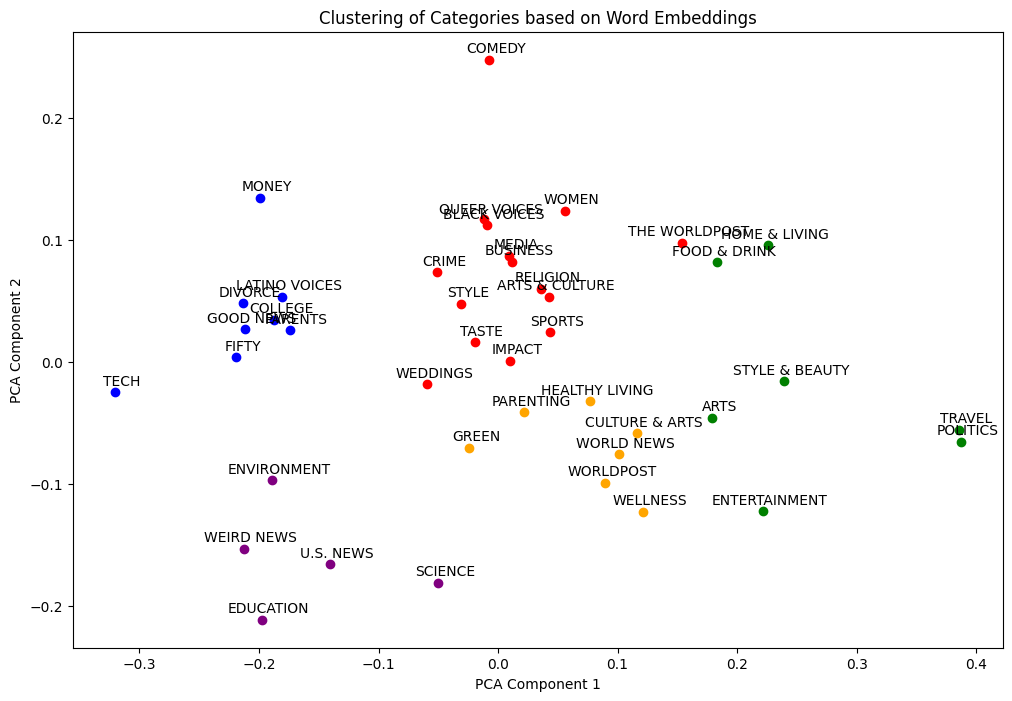

In [64]:
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple', 5: 'yellow'}

# Plot
plt.figure(figsize=(12, 8))
for category, cluster, vec_pca in zip(grouped['category'], grouped['cluster'], category_vecs_pca):
    plt.scatter(vec_pca[0], vec_pca[1], color=colors[cluster], label=category)
    plt.annotate(category, (vec_pca[0], vec_pca[1]), textcoords="offset points", xytext=(5, 5), ha='center')

# Plot Labels
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering of Categories based on Word Embeddings')
plt.show()

In [68]:
# Apply PCA
pca = PCA(n_components=3)
category_vecs_pca = pca.fit_transform(list(category_vectors.values()))

# K-means Clustering
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, n_init = 10)
kmeans.fit(category_vecs_pca)

# Cluster Labels
cluster_labels = kmeans.labels_
grouped['cluster'] = cluster_labels

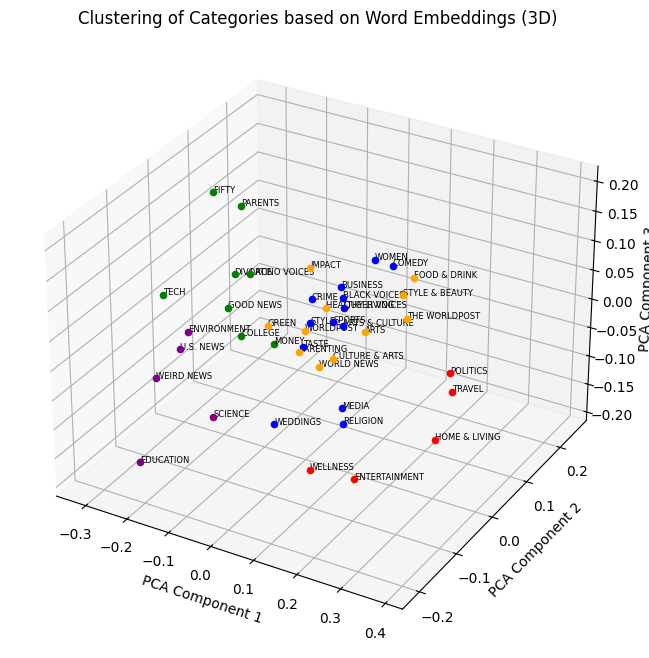

In [69]:
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple', 5: 'yellow'}  # Add more colors if needed

# Create Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Categories
for category, cluster, vec_pca in zip(grouped['category'], grouped['cluster'], category_vecs_pca):
    ax.scatter(vec_pca[0], vec_pca[1], vec_pca[2], color=colors[cluster], label=category)
    ax.text(vec_pca[0], vec_pca[1], vec_pca[2], category, color='black', fontsize=6)

# Plot Labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Clustering of Categories based on Word Embeddings (3D)')
plt.show()

In [75]:
for index, row in grouped.iterrows():
    category = row['category']
    cluster = row['cluster']
    print(f"Category: {category}, Cluster: {cluster}")

Category: ARTS, Cluster: 3
Category: ARTS & CULTURE, Cluster: 1
Category: BLACK VOICES, Cluster: 1
Category: BUSINESS, Cluster: 1
Category: COLLEGE, Cluster: 2
Category: COMEDY, Cluster: 1
Category: CRIME, Cluster: 1
Category: CULTURE & ARTS, Cluster: 3
Category: DIVORCE, Cluster: 2
Category: EDUCATION, Cluster: 4
Category: ENTERTAINMENT, Cluster: 0
Category: ENVIRONMENT, Cluster: 4
Category: FIFTY, Cluster: 2
Category: FOOD & DRINK, Cluster: 3
Category: GOOD NEWS, Cluster: 2
Category: GREEN, Cluster: 3
Category: HEALTHY LIVING, Cluster: 3
Category: HOME & LIVING, Cluster: 0
Category: IMPACT, Cluster: 3
Category: LATINO VOICES, Cluster: 2
Category: MEDIA, Cluster: 1
Category: MONEY, Cluster: 2
Category: PARENTING, Cluster: 3
Category: PARENTS, Cluster: 2
Category: POLITICS, Cluster: 0
Category: QUEER VOICES, Cluster: 1
Category: RELIGION, Cluster: 1
Category: SCIENCE, Cluster: 4
Category: SPORTS, Cluster: 1
Category: STYLE, Cluster: 1
Category: STYLE & BEAUTY, Cluster: 3
Category: TAST

#### Word2Vec, PCA, KMeans Findings:
After using Word2Vec to vectorize the processed words for each of the categories, I used PCA to reduce the dimensions to 2 and 3 and used kmeans to group the categories according to the likeness of their word vectors. I found that k=5 to be an appropriate value based on the 2d plot. The points which appear closer and share a common cluster color are considered to be more like one another. I did both 2D and 3D PCA to see if the visualizations yielded different insights. Most of the cluster elements are the same between the two. <br>
<br>
The categories fall into 5 clusters (from 3D PCA): <br>
0: ENTERTAINMENT, HOME & LIVING, POLITICS, TRAVEL, WELLNESS, QUEER VOICES, RELIGION, TASTE <br>
1: ARTS & CULTURE, BLACK VOICES, BUSINESS, COMEDY, MEDIA, SPORTS, STYLE, WEDDINGS, WOMEN <br>
2: COLLEGE, DIVORCE, FIFTY, GOOD NEWS, LATINO VOICES, MONEY, PARENTS, TECH <br>
3: ARTS, CULTURE & ARTS, FOOD & DRINK, HEALTHY LIVING, IMPACT, PARENTING, STYLE & BEAUTY, THE WORLDPOST, WORLD NEWS, WORLDPOST <br>
4: EDUCATION, ENVIRONMENT, SCIENCE, U.S. NEWS, WEIRD NEWS <br>
<br>
I found many points of interest among these graphs and cluster of categories. Some things I found predictable, and other less so. I found cluster 4 to be realistic as it grouped together EDUCATION, ENVIRONEMENT, and SCIENCE which are all topics I would consider adjacent to one another. On the humorous side, I was enamored to see FIFTY (articles for people 50 and up), DIVORCE, and PARENTS together in cluster 2. These groupings indicate to me that in some sense, the vectorization and clustering was successful. <br>
<br>
While some things may have fell into separate clusters due to the number of clusters chosen, I noticed that some similar topics were still close to one another by euclidian distance due to similarities. For example, ARTS and CULTURE & ARTS were in separate clustes in the 2D plot but were similar in their prinicple component values as the articles likely contained similar text. <br>
<br>
Not all clusters and proximities made sense though. For example, the categories PARENTS and PARENTING were both in separate clusters and far apart by their principal component values. Intuitively by their names, I would have assumed that those news article categories would have more overlap in text.

## Category Keywords using TF-IDF:
Lets try to analyze the key words that differentiate each category from one another. To do this we will use tf-idf (term frequency- inverse term frequency).

In [23]:
grouped = news_data_processed_combined_df.groupby('category')['combined_text'].apply(' '.join).reset_index()

# TF-IDF Vectorization
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(grouped['combined_text'])

# Extracting keywords for each category
keywords_per_category = {}
for i, category in enumerate(grouped['category']):
    feature_names = tfidf.get_feature_names_out()
    feature_index = tfidf_matrix[i, :].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
    sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:10]  # Select top 10 keywords
    keywords_per_category[category] = [feature_names[i] for i, _ in sorted_tfidf_scores]

# Displaying keywords for each category
for category, keywords in keywords_per_category.items():
    print(f"Category: {category}")
    print(f"Keywords: {', '.join(keywords)}")
    print()

Category: ARTS
Keywords: art, artist, new, nighter, one, work, year, music, theatr, opera

Category: ARTS & CULTURE
Keywords: art, artist, book, new, woman, trump, make, year, show, one

Category: BLACK VOICES
Keywords: black, polic, new, woman, say, life, peopl, said, year, white

Category: BUSINESS
Keywords: busi, compani, new, year, work, make, time, peopl, job, one

Category: COLLEGE
Keywords: colleg, student, univers, campu, educ, school, sexual, graduat, say, new

Category: COMEDY
Keywords: trump, donald, colbert, video, maher, show, jimmi, fallon, stephen, like

Category: CRIME
Keywords: polic, man, kill, shoot, say, suspect, said, offic, allegedli, arrest

Category: CULTURE & ARTS
Keywords: imageblog, art, photo, artist, new, work, exhibit, galleri, world, week

Category: DIVORCE
Keywords: divorc, marriag, ex, child, get, one, relationship, date, life, parent

Category: EDUCATION
Keywords: school, educ, student, teacher, child, colleg, charter, learn, devo, new

Category: ENTER

In the output of the cell above we are provided the keywords with the highest weights for each category from the tf-idf algorithm. At a quick glance, we can see how effectively that this method worked in differentiating important key words of each category. <br>
<br>
Since we used stemming, many of the key words have been reduced down to sometimes challenging stems to identify which do not obviously represent recognizable english. Some of these words include 'fark'. Luckily, with some inference, most of the other stems can be made out to their original forms. It may be better to not use stemming and just use lemmatization for this type of analysis in the future. <br>
<br>
While most categories contained predictable keywords, I thought one category in particular jumped out as humorous, no pun intended. The category 'COMEDY's top two keywords were 'trump' and 'donald.' <br>
<br>
Some categories had predictable overlap. 'ARTS' and 'ARTS & CULTURE' both had four keywords in common among their top 10. They were as follows: art, artist, new, and year. I was impressed that the RNN created to predict categories earlier was capable of differentiating these two despite containing similar text keywords. <br>
<br>
These keywords may provide insight into why the model struggled to predict some of the categories. The categories in which the model struggled most were GOOD NEWS, U.S. NEWS, and TASTE. We can now see that these categories either contained words common among all categories and or contained significant overlap with other particular categories. For example, TASTE shares many keywords with FOOD & DRINK. Likewise, U.S. NEWS and GOOD NEWS overlapped heavily with other WORLD and NEWS type categories. <br>
<br>
Some keywords appeared among the top 10 of many categories. These words include: day, year, one, new, etc. It may be useful to make a list of the most frequent keywords across the categories and add that to a list of words to remove in the preprocessing to further enhance the differences between one another for predictive analysis. <br>

## Citations:
1. Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).